In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
from google.colab import files
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import Subset
from collections import Counter
import os
import shutil
from torchvision import datasets
import pickle

In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
set_seed()

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
train_set = ImageFolder(root='train//', transform=transform)
validate_set = ImageFolder(root='valid//', transform=transform)
test_set = ImageFolder(root='test//', transform=transform)

In [7]:
class_names = train_set.classes
num_labels = len(class_names)
print(class_names)
print(num_labels)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10


In [8]:
data_loader = DataLoader(train_set, batch_size=64, num_workers=2, pin_memory=True, shuffle=True)
data_loader_val = DataLoader(validate_set, batch_size=64, num_workers=2, pin_memory=True, shuffle=False)
data_loader_test = DataLoader(test_set, batch_size=64, num_workers=2, shuffle=False)

In [9]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return 0 (or GPU index)
print(torch.cuda.get_device_name(0))  # Should return GPU name (e.g., Tesla T4)}

True
0
Tesla T4


In [10]:
model1 = nn.Sequential(
    # Block 1: 32x32x3 -> 16x16x32
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.2),

    # Block 2: 16x16x32 -> 8x8x64
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.3),

    # Block 3: 8x8x64 -> 4x4x128
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.4),

    # Classifier
    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

In [11]:
model2 = nn.Sequential(
    # Block 1: 32x32x3 -> 16x16x32
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.2),

    # Block 2: 16x16x32 -> 8x8x64
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.25),

    # Block 3: 8x8x64 -> 4x4x128
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.3),

    # Classifier
    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 512),
    nn.ReLU(),
    nn.Dropout(0.35),
    nn.Linear(512, 10)
)

In [12]:
model3 = nn.Sequential(
    # Block 1: 32x32x3 -> 16x16x32
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.35),

    # Block 2: 16x16x32 -> 8x8x64
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.4),

    # Block 3: 8x8x64 -> 4x4x128
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.45),

    # Classifier
    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

In [ ]:
optimizer = torch.optim.Adam(model1.parameters(), lr=0.003)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)
criterion = nn.CrossEntropyLoss()

In [13]:
def train(model, train_loader, optimizer, device):
    model.train()
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [14]:
def validate(model, val_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
num_epochs = 50
train_losses, train_accs = [], []
val_losses, val_accs = [], []

In [ ]:
for epoch in range(num_epochs):
    train_loss, train_acc = train(model1, data_loader, optimizer, device)
    val_loss, val_acc = validate(model1, data_loader_val, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

Epoch 1/50: Train Loss: 1.2694 | Train Acc: 54.34% | Val Loss: 1.1216 | Val Acc: 59.01%
Epoch 2/50: Train Loss: 1.2012 | Train Acc: 57.05% | Val Loss: 1.1053 | Val Acc: 60.14%
Epoch 3/50: Train Loss: 1.1505 | Train Acc: 58.97% | Val Loss: 1.0223 | Val Acc: 62.97%
Epoch 4/50: Train Loss: 1.1096 | Train Acc: 60.66% | Val Loss: 1.0194 | Val Acc: 63.44%
Epoch 5/50: Train Loss: 1.0703 | Train Acc: 62.13% | Val Loss: 0.9964 | Val Acc: 64.17%
Epoch 6/50: Train Loss: 1.0426 | Train Acc: 63.10% | Val Loss: 0.9779 | Val Acc: 64.82%
Epoch 7/50: Train Loss: 1.0142 | Train Acc: 64.15% | Val Loss: 0.9353 | Val Acc: 66.50%
Epoch 8/50: Train Loss: 0.9939 | Train Acc: 64.81% | Val Loss: 0.8918 | Val Acc: 67.89%
Epoch 9/50: Train Loss: 0.9772 | Train Acc: 65.70% | Val Loss: 0.9088 | Val Acc: 67.32%
Epoch 10/50: Train Loss: 0.9560 | Train Acc: 66.34% | Val Loss: 0.9116 | Val Acc: 67.99%
Epoch 11/50: Train Loss: 0.9422 | Train Acc: 67.03% | Val Loss: 0.9167 | Val Acc: 67.23%
Epoch 12/50: Train Loss: 0.928

In [15]:
def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader)
    test_acc = 100 * correct / total
    return test_loss, test_acc, all_preds, all_targets

In [ ]:
test_loss, test_acc, all_preds, all_targets = test(model1, data_loader_test, device)
print(f"\nFinal Test Results: Loss: {test_loss:.4f} | Accuracy: {test_acc:.2f}%")


Final Test Results: Loss: 0.7603 | Accuracy: 73.84%


In [16]:
def plot_confusion_matrix(targets, predictions, class_names):
    """
    Plots a confusion matrix.
    Args:
        targets: Ground truth labels.
        predictions: Predicted labels.
        class_names: List of class names.
    """
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

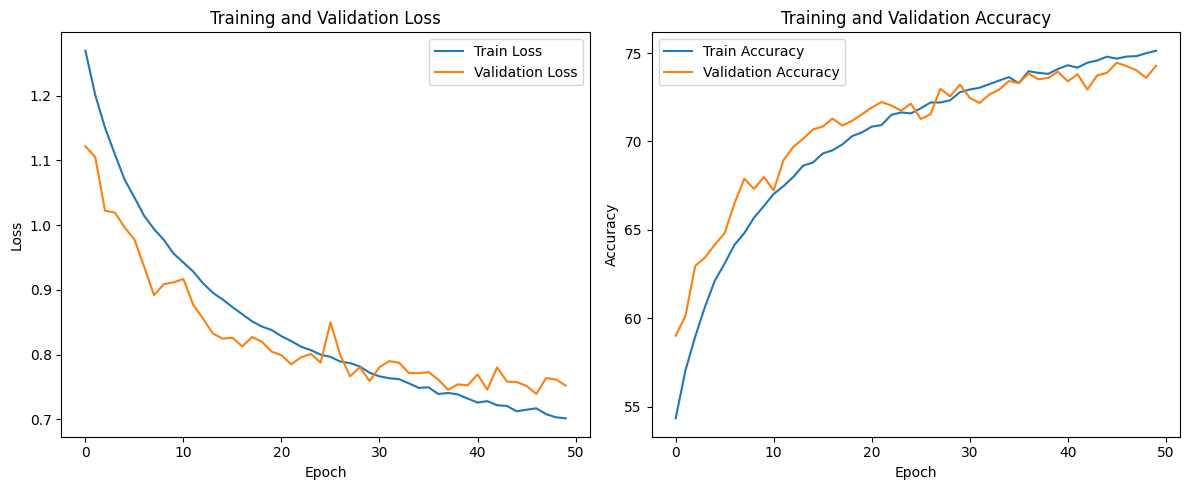

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

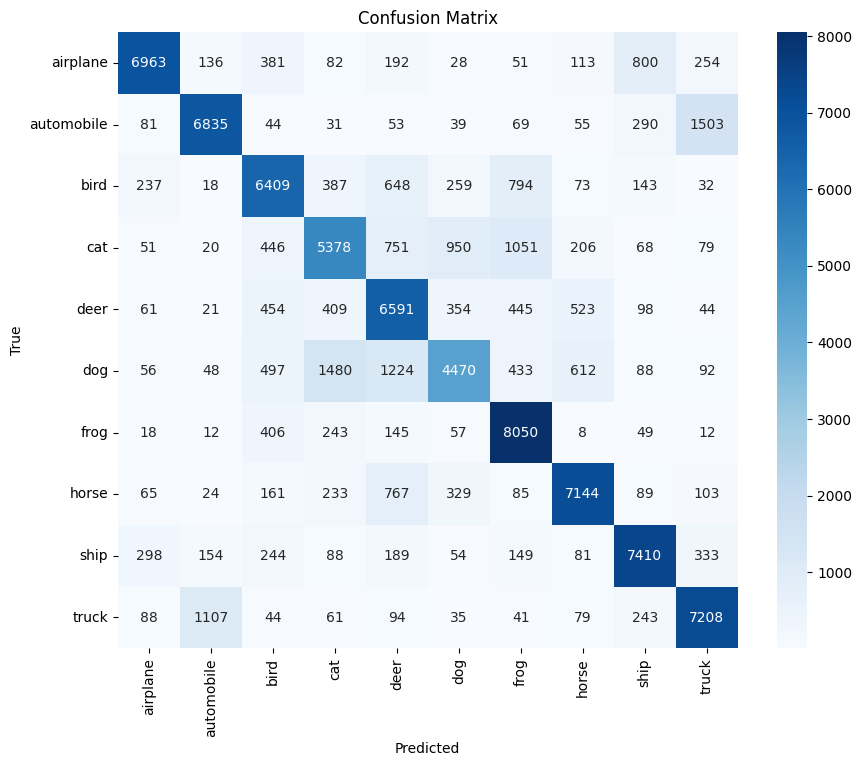

In [ ]:
plot_confusion_matrix(all_targets, all_preds, class_names)

In [ ]:
torch.save(model1.state_dict(), "dropout_model1.pth")

In [ ]:
files.download("dropout_model1.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model1.load_state_dict(torch.load("dropout_1_model.pth"))

<All keys matched successfully>

In [ ]:
with open('metrics1.pkl', 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }, f)

In [ ]:
with open('metrics1.pkl', 'rb') as f:
    metrics1 = pickle.load(f)

In [ ]:
files.download("metrics1.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model 2

In [ ]:
num_epochs = 50
train_losses, train_accs = [], []
val_losses, val_accs = [], []

In [ ]:
optimizer = torch.optim.Adam(model2.parameters(), lr=0.003)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(num_epochs):
    train_loss, train_acc = train(model2, data_loader, optimizer, device)
    val_loss, val_acc = validate(model2, data_loader_val, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

Epoch 1/50: Train Loss: 1.7889 | Train Acc: 32.71% | Val Loss: 1.4769 | Val Acc: 45.82%
Epoch 2/50: Train Loss: 1.4275 | Train Acc: 47.40% | Val Loss: 1.2267 | Val Acc: 54.23%
Epoch 3/50: Train Loss: 1.2888 | Train Acc: 53.17% | Val Loss: 1.2042 | Val Acc: 56.10%
Epoch 4/50: Train Loss: 1.2048 | Train Acc: 56.79% | Val Loss: 1.0541 | Val Acc: 61.49%
Epoch 5/50: Train Loss: 1.1367 | Train Acc: 59.48% | Val Loss: 1.0394 | Val Acc: 62.53%
Epoch 6/50: Train Loss: 1.0867 | Train Acc: 61.30% | Val Loss: 0.9831 | Val Acc: 64.45%
Epoch 7/50: Train Loss: 1.0436 | Train Acc: 62.87% | Val Loss: 0.9697 | Val Acc: 65.39%
Epoch 8/50: Train Loss: 1.0004 | Train Acc: 64.66% | Val Loss: 0.9208 | Val Acc: 66.74%
Epoch 9/50: Train Loss: 0.9691 | Train Acc: 65.75% | Val Loss: 0.9309 | Val Acc: 66.55%
Epoch 10/50: Train Loss: 0.9413 | Train Acc: 66.64% | Val Loss: 0.8695 | Val Acc: 69.06%
Epoch 11/50: Train Loss: 0.9107 | Train Acc: 67.65% | Val Loss: 0.8527 | Val Acc: 69.81%
Epoch 12/50: Train Loss: 0.891

In [ ]:
test_loss, test_acc, all_preds, all_targets = test(model2, data_loader_test, device)
print(f"\nFinal Test Results: Loss: {test_loss:.4f} | Accuracy: {test_acc:.2f}%")


Final Test Results: Loss: 0.8057 | Accuracy: 73.98%


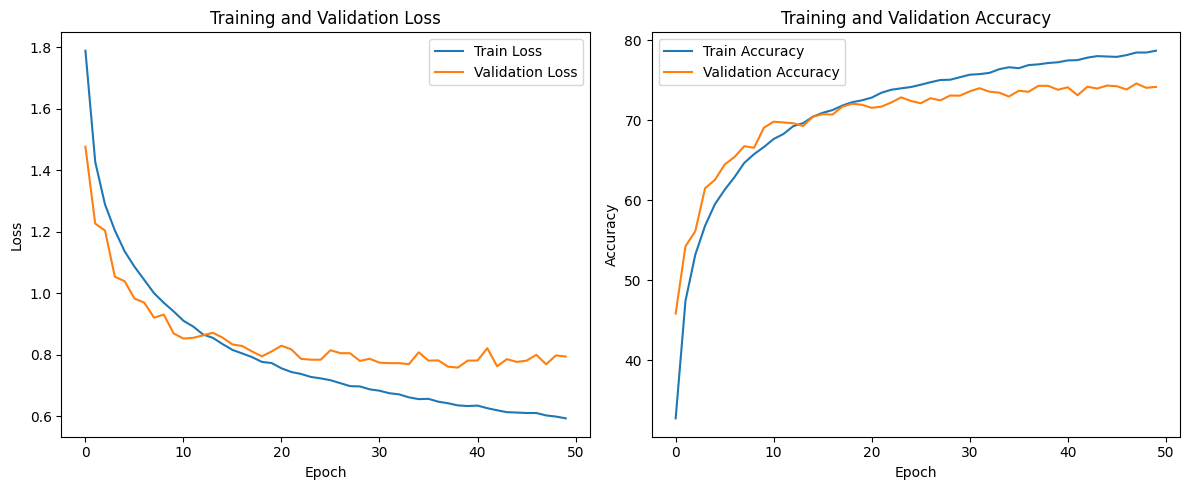

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

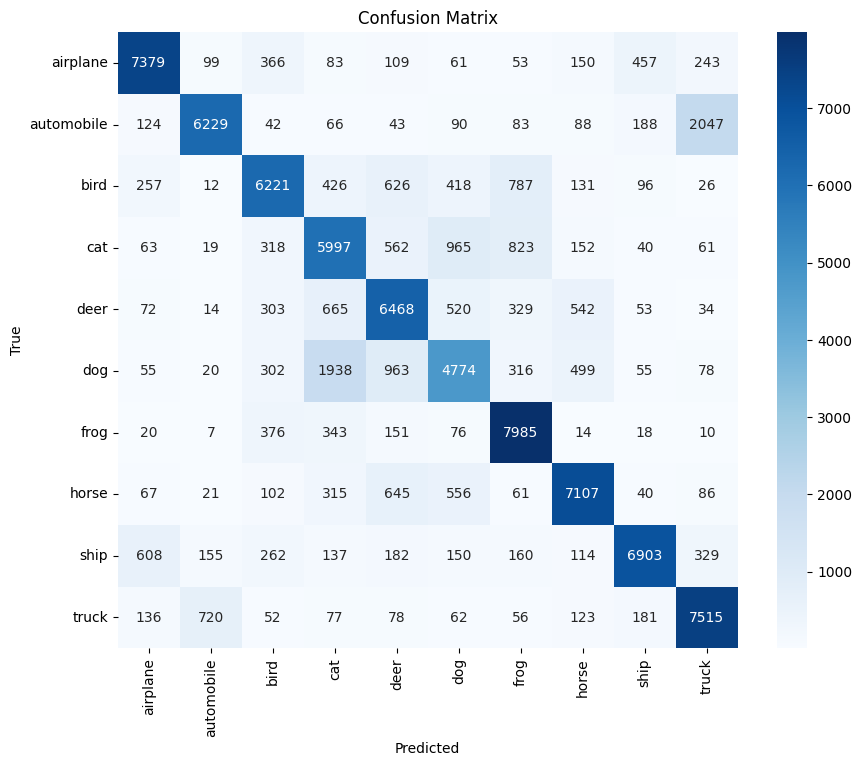

In [ ]:
plot_confusion_matrix(all_targets, all_preds, class_names)

In [ ]:
torch.save(model2.state_dict(), "dropout_model2.pth")

In [ ]:
files.download("dropout_model2.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('metrics2.pkl', 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }, f)

In [ ]:
with open('metrics2.pkl', 'rb') as f:
    metrics2 = pickle.load(f)

In [ ]:
files.download("metrics2.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model 3

In [17]:
num_epochs = 50
train_losses, train_accs = [], []
val_losses, val_accs = [], []

In [18]:
optimizer = torch.optim.Adam(model3.parameters(), lr=0.003)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = model3.to(device)
criterion = nn.CrossEntropyLoss()

In [19]:
for epoch in range(num_epochs):
    train_loss, train_acc = train(model3, data_loader, optimizer, device)
    val_loss, val_acc = validate(model3, data_loader_val, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

Epoch 1/50: Train Loss: 1.9274 | Train Acc: 25.19% | Val Loss: 1.6157 | Val Acc: 38.97%
Epoch 2/50: Train Loss: 1.5699 | Train Acc: 40.92% | Val Loss: 1.4376 | Val Acc: 46.46%
Epoch 3/50: Train Loss: 1.4087 | Train Acc: 48.55% | Val Loss: 1.2171 | Val Acc: 54.76%
Epoch 4/50: Train Loss: 1.3239 | Train Acc: 52.16% | Val Loss: 1.1550 | Val Acc: 57.82%
Epoch 5/50: Train Loss: 1.2593 | Train Acc: 54.63% | Val Loss: 1.1269 | Val Acc: 58.96%
Epoch 6/50: Train Loss: 1.2100 | Train Acc: 56.78% | Val Loss: 1.0605 | Val Acc: 61.25%
Epoch 7/50: Train Loss: 1.1767 | Train Acc: 57.81% | Val Loss: 1.0832 | Val Acc: 61.15%
Epoch 8/50: Train Loss: 1.1459 | Train Acc: 59.14% | Val Loss: 1.0264 | Val Acc: 62.91%
Epoch 9/50: Train Loss: 1.1193 | Train Acc: 60.01% | Val Loss: 1.0002 | Val Acc: 63.77%
Epoch 10/50: Train Loss: 1.0955 | Train Acc: 61.11% | Val Loss: 1.0007 | Val Acc: 63.93%
Epoch 11/50: Train Loss: 1.0729 | Train Acc: 61.96% | Val Loss: 0.9597 | Val Acc: 65.24%
Epoch 12/50: Train Loss: 1.058

In [20]:
test_loss, test_acc, all_preds, all_targets = test(model3, data_loader_test, device)
print(f"\nFinal Test Results: Loss: {test_loss:.4f} | Accuracy: {test_acc:.2f}%")


Final Test Results: Loss: 0.8438 | Accuracy: 70.22%


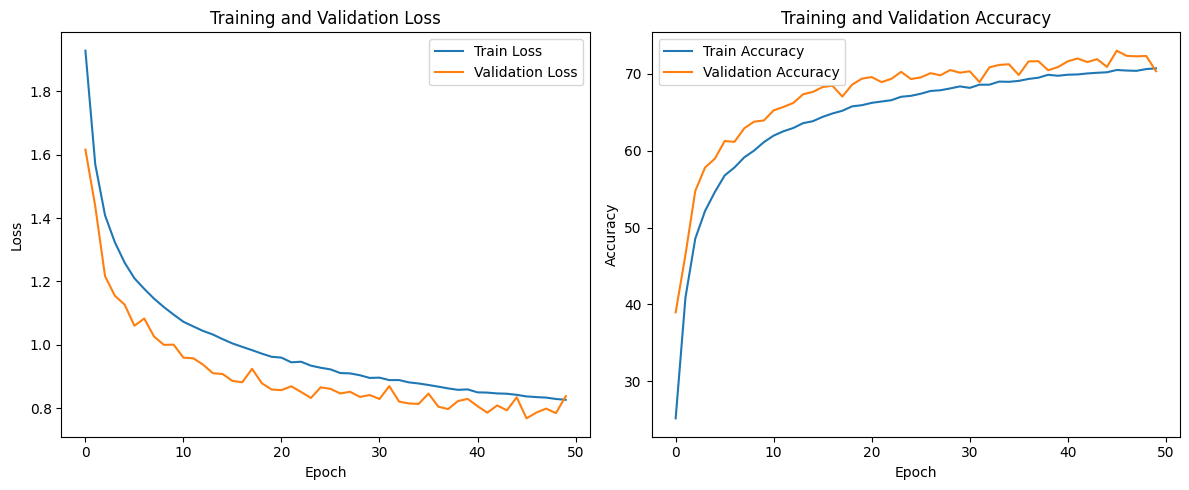

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

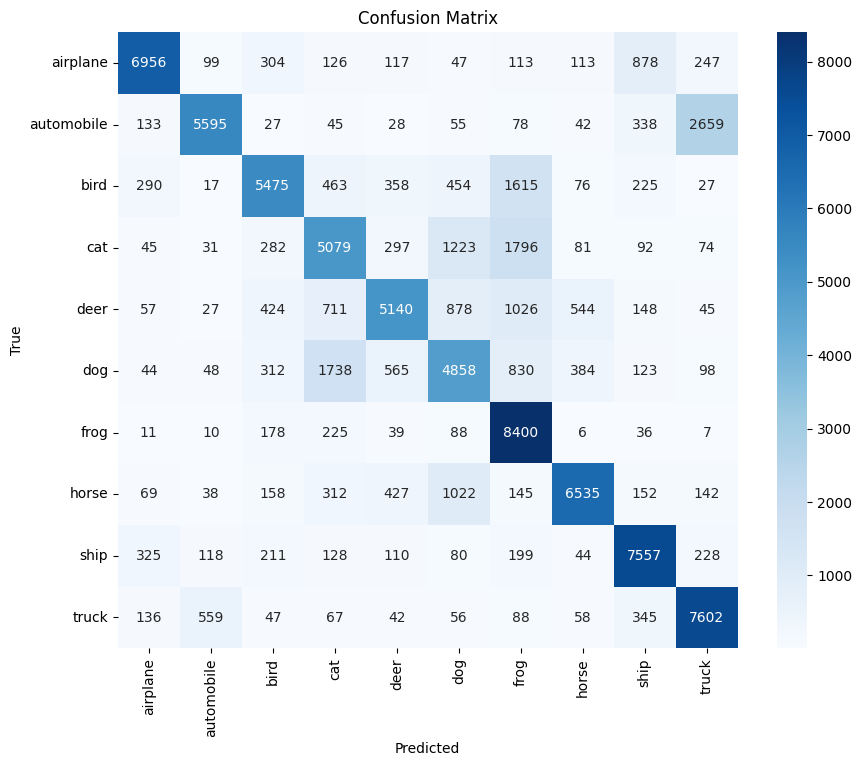

In [22]:
plot_confusion_matrix(all_targets, all_preds, class_names)

In [23]:
torch.save(model3.state_dict(), "dropout_model3.pth")

In [24]:
files.download("dropout_model3.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
with open('metrics3.pkl', 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }, f)

In [26]:
with open('metrics3.pkl', 'rb') as f:
    metrics3 = pickle.load(f)

In [27]:
files.download("metrics3.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Soft-voting

In [29]:
model1.load_state_dict(torch.load('dropout_model1.pth'))
model2.load_state_dict(torch.load('dropout_model2.pth'))
model3.load_state_dict(torch.load('dropout_model3.pth'))

<All keys matched successfully>

In [30]:
model1.eval()
model2.eval()
model3.eval()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.35, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.4, inplace=False)
  (16): Conv2d(64, 128, kernel_size=(3, 3), stri

In [32]:
def weighted_soft_vote(models, weights, test_loader, device):
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Get weighted softmax probabilities
            probs = torch.zeros_like(F.softmax(models[0](inputs), dim=1))  # Initialize

            for model, weight in zip(models, weights):
                probs += weight * F.softmax(model(inputs), dim=1)

            all_probs.append(probs)
            all_targets.append(labels)

    # Concatenate results
    all_probs = torch.cat(all_probs)
    all_targets = torch.cat(all_targets)

    # Calculate metrics
    _, preds = torch.max(all_probs, 1)
    correct = (preds == all_targets).sum().item()
    total = all_targets.size(0)
    acc = 100 * correct / total
    loss = F.cross_entropy(all_probs, all_targets).item()

    return loss, acc, preds.cpu().numpy(), all_targets.cpu().numpy()

In [33]:
models = [model1.to(device), model2.to(device), model3.to(device)]
weights = torch.tensor([0.45, 0.45, 0.10]).to(device)

In [34]:
ensemble_loss, ensemble_acc, ensemble_preds, ensemble_targets = weighted_soft_vote(
    models, weights, data_loader_test, device
)

In [35]:
print(f"Weighted Ensemble: Loss={ensemble_loss:.4f}, Accuracy={ensemble_acc:.2f}%")

Weighted Ensemble: Loss=1.7660, Accuracy=75.94%


In [36]:
weights = torch.tensor([0.6, 0.3, 0.1]).to(device)
ensemble_loss, ensemble_acc, ensemble_preds, ensemble_targets = weighted_soft_vote(
    models, weights, data_loader_test, device
)
print(f"Weighted Ensemble: Loss={ensemble_loss:.4f}, Accuracy={ensemble_acc:.2f}%")

Weighted Ensemble: Loss=1.7686, Accuracy=75.77%


In [37]:
weights = torch.tensor([0.3, 0.6, 0.1]).to(device)
ensemble_loss, ensemble_acc, ensemble_preds, ensemble_targets = weighted_soft_vote(
    models, weights, data_loader_test, device
)
print(f"Weighted Ensemble: Loss={ensemble_loss:.4f}, Accuracy={ensemble_acc:.2f}%")

Weighted Ensemble: Loss=1.7638, Accuracy=75.59%


## Comparison

In [39]:
with open('metrics1.pkl', 'rb') as f:
    metrics1 = pickle.load(f)

with open('metrics2.pkl', 'rb') as f:
    metrics2 = pickle.load(f)

with open('metrics3.pkl', 'rb') as f:
    metrics3 = pickle.load(f)

In [44]:
from matplotlib.offsetbox import AnchoredText

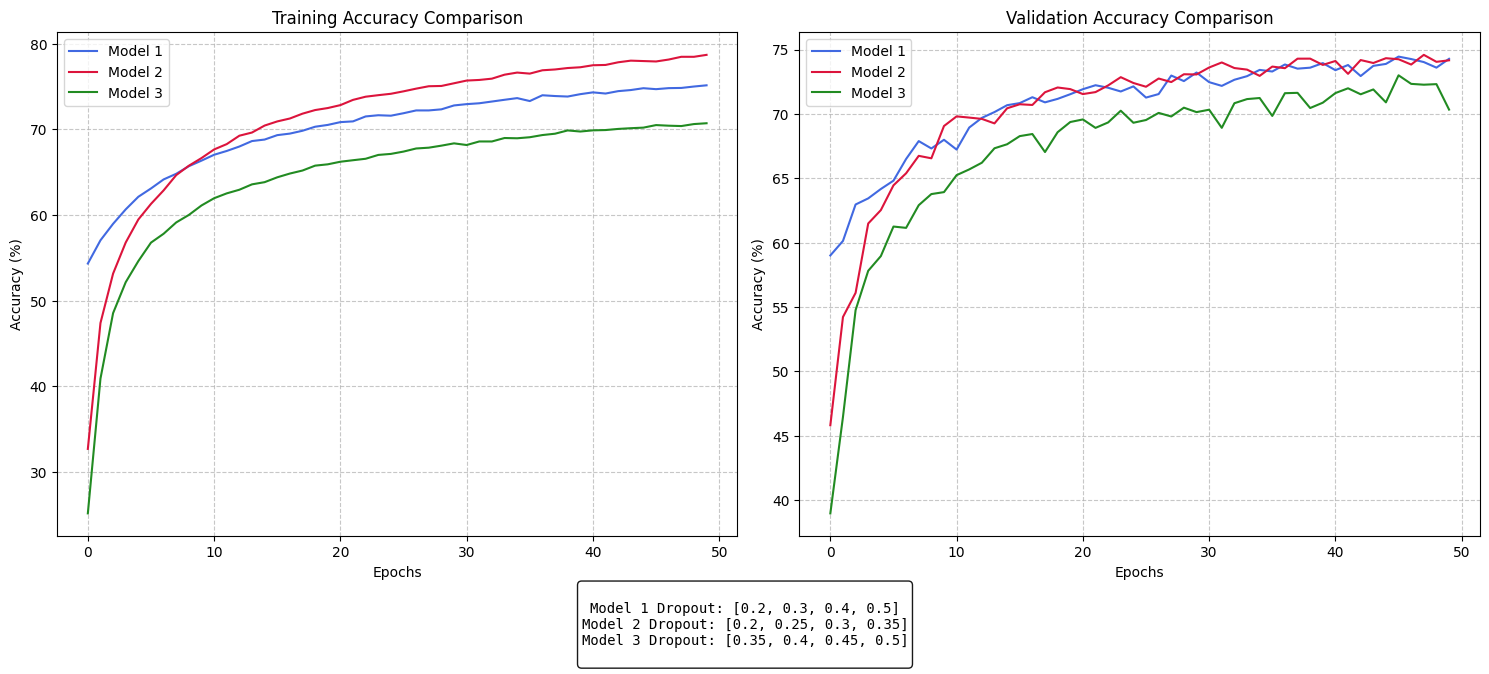

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(metrics1['train_accs'], label='Model 1', color='royalblue')
ax1.plot(metrics2['train_accs'], label='Model 2', color='crimson')
ax1.plot(metrics3['train_accs'], label='Model 3', color='forestgreen')
ax1.set_title('Training Accuracy Comparison')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

ax2.plot(metrics1['val_accs'], label='Model 1', color='royalblue')
ax2.plot(metrics2['val_accs'], label='Model 2', color='crimson')
ax2.plot(metrics3['val_accs'], label='Model 3', color='forestgreen')
ax2.set_title('Validation Accuracy Comparison')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

hyperparams_text = """
Model 1 Dropout: [0.2, 0.3, 0.4, 0.5]
Model 2 Dropout: [0.2, 0.25, 0.3, 0.35]
Model 3 Dropout: [0.35, 0.4, 0.45, 0.5]
"""

fig.text(0.5, -0.05, hyperparams_text,
         ha='center', va='center',
         bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round'),
         fontfamily='monospace', fontsize=10)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

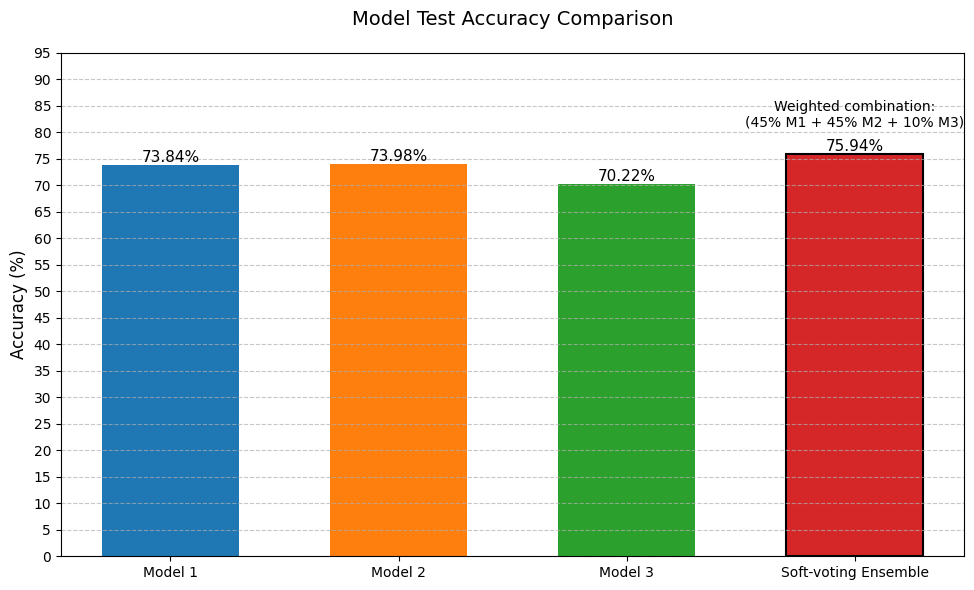

In [62]:
models_list = ['Model 1', 'Model 2', 'Model 3', 'Soft-voting Ensemble']
accuracies_list = [73.84, 73.98, 70.22, 75.94]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

plt.figure(figsize=(10, 6))

bars = plt.bar(models_list, accuracies_list, color=colors, width=0.6)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=11)

plt.title('Model Test Accuracy Comparison', fontsize=14, pad=20)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.yticks(np.arange(0, 100, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)

bars[-1].set_edgecolor('black')
bars[-1].set_linewidth(1.5)

plt.annotate('Weighted combination:\n(45% M1 + 45% M2 + 10% M3)',
             xy=(3, 75.94), xytext=(3, 81),
             ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('model_accuracies_comparison.png', dpi=300, bbox_inches='tight')
plt.show()